Let's see how Resnet do the task of segmentation

In [1]:
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import os
import sys
import random
import warnings

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Set some parameters
imgWidth = 128
imgHeight = 128
imgChannel = 3
trainPath = "./U_NET/train/"
testPath = "./U_NET/validation/"

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


Collect our files names for train and test data

In [2]:
train_ids = next(os.walk(trainPath))[1]
test_ids = next(os.walk(testPath))[1]

Creating the image masks of dimension 128 x 128 (only for black images)

In [3]:
print("Getting and resizing all the training images\n")

X_train = np.zeros((len(train_ids), imgHeight, imgWidth, imgChannel), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), imgHeight, imgWidth, 1), dtype = np.bool)

Getting and resizing all the training images



Let's use TQDM to create our progress bars

In [4]:
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()


for n, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
    
    path = trainPath + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:imgChannel]
    img = resize(img, (imgHeight, imgWidth), mode = "constant", preserve_range = True)
    X_train[n] = img
    mask = np.zeros((imgHeight, imgWidth, 1), dtype = np.bool)
    
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (imgHeight, imgWidth), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), imgHeight, imgWidth, imgChannel), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = testPath + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:imgChannel]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (imgHeight, imgWidth), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 
Getting and resizing test images ... 
Done!


100%|██████████| 65/65 [00:01<00:00, 43.32it/s]


Illustrate the train images and masks

/home/borin/anaconda3/envs/CursoDLECV/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


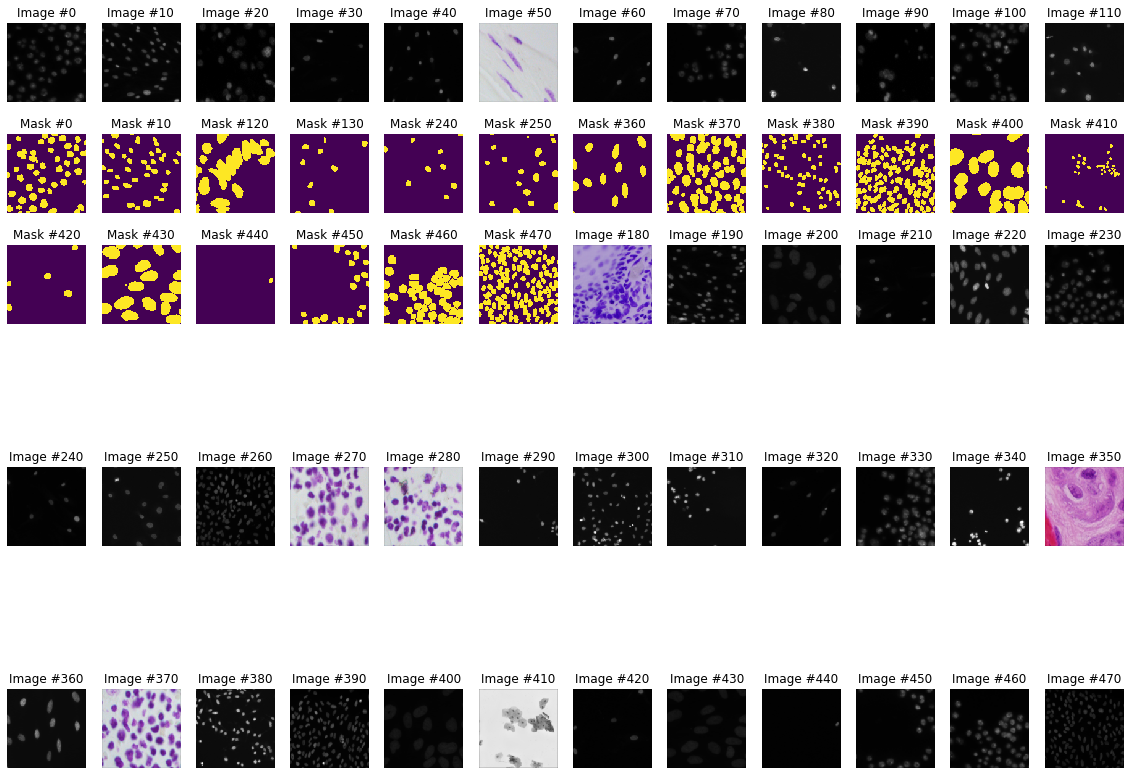

In [5]:
plt.figure(figsize = (20, 16))
x, y = 12, 4

for i in range(y):
    
    for j in range(x):
        
        plt.subplot(y * 2, x, i * 2 * x + j + 1)
        pos = i * 120 + j * 10
        plt.imshow(X_train[pos])
        plt.title("Image #{}".format(pos))
        plt.axis("off")
        plt.subplot(y * 2, x, i * 2 + 1 * x + j + 1)
        
        # We now display the associated mask we just generated above with the training image
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title("Mask #{}".format(pos))
        plt.axis("off")

plt.show()

Now, let's define a custom metric called Intersection over union (IoU)

In [6]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
    
        matches = iou > threshold
    
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    
    if print_table:
    
        print("Thresh\tTP\tFP\tFN\tPrec.")
    
    for t in np.arange(0.5, 1.0, 0.05):
    
        tp, fp, fn = precision_at(t, iou)
    
        if (tp + fp + fn) > 0:
    
            p = tp / (tp + fp + fn)
    
        else:
    
            p = 0
    
        if print_table:
    
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
    
        prec.append(p)
    
    if print_table:
    
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    
    batch_size = y_true_in.shape[0]
    metric = []
    
    for batch in range(batch_size):
    
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
    
        metric.append(value)
    
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    
    return metric_value

Build our U-Net Model

In [7]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.initializers import glorot_uniform

def _identity_block(X, f, filters, stage, block):
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a',
                   kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b',
                   kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c',
                   kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [8]:
def _convolutional_block(X, f, filters, stage, block, s=2):
    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

     # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a',
                   kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b',
                   kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c',
                   kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1',
                            kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [21]:
K.clear_session()

# Build U-Net model
inputs = Input((imgHeight, imgWidth, imgChannel))
X = Lambda(lambda x: x ) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (X)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
#c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
c2 = _convolutional_block(c2, f=3, filters=[16, 16, 64], stage=2, block='a2', s=1)
X = _identity_block(c2, 3, [16, 16, 64], stage=2, block='b2')
X = _identity_block(X, 3, [16, 16, 64], stage=2, block='c2')
p2 = MaxPooling2D((2, 2)) (X)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
#c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
c3 = _convolutional_block(c3, f=3, filters=[32, 32, 128], stage=3, block='a3', s=2)
X = _identity_block(c3, 3, [32, 32, 128], stage=3, block='b3')
X = _identity_block(X, 3, [32, 32, 128], stage=3, block='c3')
X = _identity_block(X, 3, [32, 32, 128], stage=3, block='d3')
p3 = MaxPooling2D((2, 2)) (X)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
#c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
c4 = _convolutional_block(c4, f=3, filters=[64, 64, 512], stage=4, block='a4', s=2)
X = _identity_block(c4, 3, [64, 64, 512], stage=4, block='b4')
X = _identity_block(X, 3, [64, 64, 512], stage=4, block='c4')
X = _identity_block(X, 3, [64, 64, 512], stage=4, block='d4')
X = _identity_block(X, 3, [64, 64, 512], stage=4, block='e4')
X = _identity_block(X, 3, [64, 64, 512], stage=4, block='f4')
p4 = MaxPooling2D(2, 2) (X)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
#u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (u6)
u6 = concatenate([u6, c4])
X = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
X = _convolutional_block(X, f=3, filters=[64, 64, 512], stage=4, block='a6', s=2)
X = _identity_block(X, 3, [64, 64, 512], stage=3, block='b6')
X = _identity_block(X, 3, [64, 64, 512], stage=3, block='c6')
X = _identity_block(X, 3, [64, 64, 512], stage=3, block='d6')
X = _identity_block(X, 3, [64, 64, 512], stage=3, block='e6')
X = _identity_block(X, 3, [64, 64, 512], stage=3, block='f6')

u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (X)
u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (u7)
u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (u7)
u7 = concatenate([u7, c3])
X = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
X = _convolutional_block(X, f=3, filters=[32, 32, 128], stage=3, block='a7', s=2)
X = _identity_block(X, 3, [32, 32, 128], stage=3, block='b7')
X = _identity_block(X, 3, [32, 32, 128], stage=3, block='c7')
X = _identity_block(X, 3, [32, 32, 128], stage=3, block='d7')

u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (X)
u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (u8)
u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (u8)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
X = _convolutional_block(X, f=3, filters=[16, 16, 64], stage=2, block='a8', s=1)
X = _identity_block(X, 3, [16, 16, 64], stage=2, block='b8')
X = _identity_block(X, 3, [16, 16, 64], stage=2, block='c8')

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (X)
u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (u9)
u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (u9)
u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (u9)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

Fit our Model

In [22]:
modelPath = "./NucleiFinder.h5"

checkpoint = ModelCheckpoint(modelPath, monitor = "val_loss",
                            mode = "min", save_best_only = True,
                            verbose = 1)

earlyStop = EarlyStopping(monitor = "val_loss", min_delta = 0,
                          patience = 5, verbose = 1,
                          restore_best_weights = True)

# Fit Our Model
results = model.fit(X_train, Y_train, validation_split = 0.1,
                    batch_size = 8, epochs = 10,
                    callbacks = [earlyStop, checkpoint])

Train on 603 samples, validate on 67 samples
Epoch 1/10
603/603 [==============================] - 244s 405ms/step - loss: 0.5497 - my_iou_metric: 0.0734 - val_loss: 2.0021 - val_my_iou_metric: 0.0430

Epoch 00001: val_loss improved from inf to 2.00207, saving model to ./NucleiFinder.h5
Epoch 2/10
603/603 [==============================] - 200s 332ms/step - loss: 0.3114 - my_iou_metric: 0.2063 - val_loss: 0.3231 - val_my_iou_metric: 0.2348

Epoch 00002: val_loss improved from 2.00207 to 0.32315, saving model to ./NucleiFinder.h5
Epoch 3/10
603/603 [==============================] - 201s 334ms/step - loss: 0.2467 - my_iou_metric: 0.2531 - val_loss: 0.2133 - val_my_iou_metric: 0.2751

Epoch 00003: val_loss improved from 0.32315 to 0.21328, saving model to ./NucleiFinder.h5
Epoch 4/10
603/603 [==============================] - 201s 333ms/step - loss: 0.2060 - my_iou_metric: 0.2937 - val_loss: 0.2454 - val_my_iou_metric: 0.2415

Epoch 00004: val_loss did not improve from 0.21328
Epoch 5/10

In [24]:
callbacks = [earlyStop, checkpoint]# Predict on train, val and test
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 5s 75ms/step


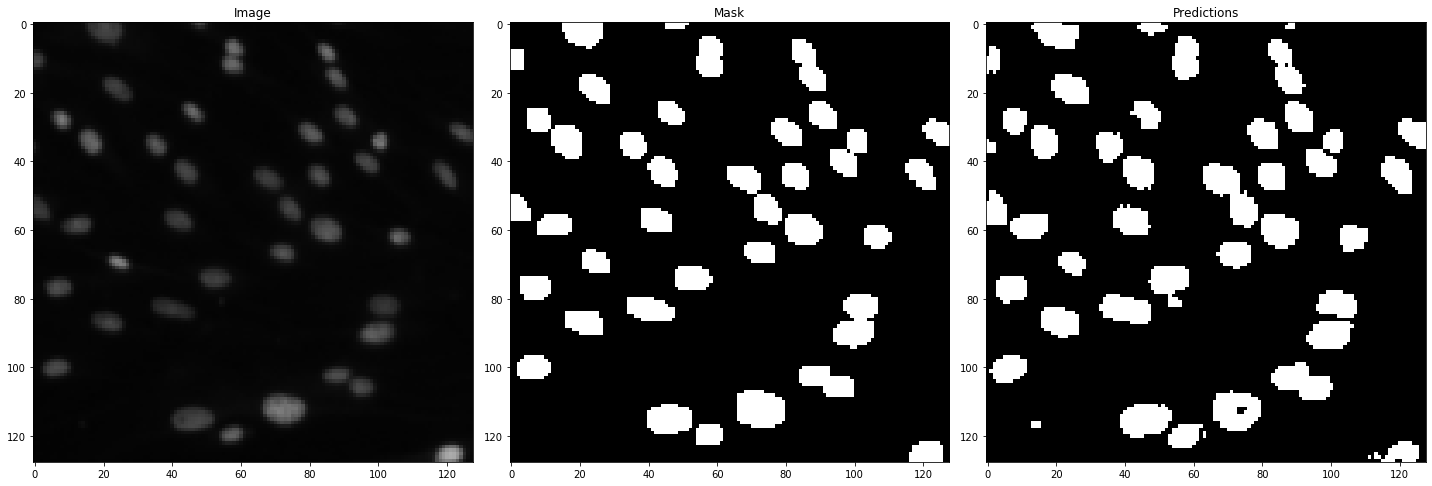

In [25]:
from skimage.io import imshow

ix = 10
plt.figure(figsize=(20,20))
plt.subplot(131)
imshow(X_train[ix])
plt.title("Image")
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix] > 0.5))
plt.title("Predictions")
plt.show()


Ploting the Loss Charts 

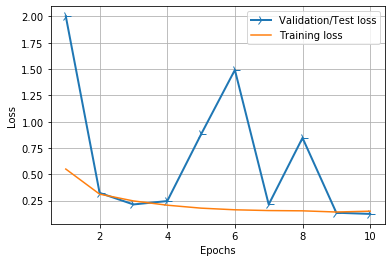

In [26]:
historyDict = results.history

lossValues = historyDict["loss"]
valLossValues = historyDict["val_loss"]
epochs = range(1, len(lossValues) + 1)

line1 = plt.plot(epochs, valLossValues, label = "Validation/Test loss")
line2 = plt.plot(epochs, lossValues, label = "Training loss")
plt.setp(line1, linewidth = 2.0, marker = "+", markersize = 10.0)
plt.setp(line1, linewidth = 2.0, marker = "4", markersize = 10.0)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

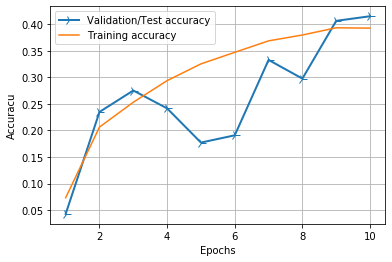

In [28]:
accValues = historyDict["my_iou_metric"]
valAccValues = historyDict["val_my_iou_metric"]

line1 = plt.plot(epochs, valAccValues, label = "Validation/Test accuracy")
line2 = plt.plot(epochs, accValues, label = "Training accuracy")
plt.setp(line1, linewidth = 2.0, marker = "+", markersize = 10.0)
plt.setp(line1, linewidth = 2.0, marker = "4", markersize = 10.0)
plt.xlabel("Epochs")
plt.ylabel("Accuracu")
plt.grid(True)
plt.legend()
plt.show()